In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import regularizers
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np

import cv2

from imageutils import block_dct
from imageutils import dataset_transform_block_dct

import random

/home/jmoore/.virtualenvs/dl4cv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('[INFO] loading MNIST full dataset...')
dataset = datasets.fetch_mldata("MNIST Original")

[INFO] loading MNIST full dataset...


In [3]:
print(len(dataset))
print(dataset.data.shape)
print(dataset.data.__class__)

4
(70000, 784)
<class 'numpy.ndarray'>


In [4]:
# Traditional NNet setup, linearize the image
data = dataset.data.astype("float") / 255.0
(trainX, testX, trainY, testY) = train_test_split(data, dataset.target, test_size=0.25)

In [5]:
# Reshape for CNN
data = dataset.data.astype("float").reshape(70000, 28, 28, 1) / 255.0
#data = 1.0-data
(trainX, testX, trainY, testY) = train_test_split(data, dataset.target, test_size=0.33)

(28, 28, 1)
(48, 48, 1)


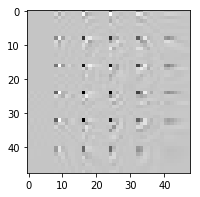

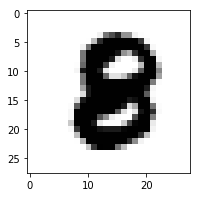

In [15]:
im = trainX[0,:,:,:]
print(im.shape)

im_dct = block_dct(im)
print(im_dct.shape)

show_2d(im.reshape(28,28))
show_2d(im_dct.reshape((48,48)))


In [7]:
print(data.shape)
print(trainX.shape)
print(testX.shape)


(70000, 28, 28, 1)
(46900, 28, 28, 1)
(23100, 28, 28, 1)


In [8]:
trainX_dct = dataset_transform_block_dct(trainX, dct_size=8, stride=4)
testX_dct = dataset_transform_block_dct(testX, dct_size=8, stride=4)

In [9]:
print(trainX_dct.shape)
print(testX_dct.shape)

(46900, 48, 48, 1)
(23100, 48, 48, 1)


In [22]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)

print(lb.classes_)
print(lb.classes_.shape)

(46900, 10)
(23100, 10)
[0 1 2 3 4 5 6 7 8 9]
(10,)


In [6]:
# define 784-256-128-10 architecture with Keras
model = Sequential()
model.add(Dense(256, input_shape=(784,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# define 784-256-128-10 architecture with Keras
model = Sequential()
model.add(Dense(128, input_shape=(784,), activation="relu",
          activity_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.1))
model.add(Dense(32, activation="relu",
          activity_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [375]:
# Simple CNN architecture with Keras
model = Sequential()
model.add(Conv2D(input_shape=(28,28,1), filters=16, padding='same', 
                 use_bias=True, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, use_bias=True, kernel_size=(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(filters=32, use_bias=False, kernel_size=(2,2)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# "Transform" CNN architecture with Keras
model = Sequential()
model.add(Conv2D(input_shape=(48,48,1), filters=16,  
                 use_bias=True, kernel_size=(8,8), strides=8))
model.add(Activation('relu'))
model.add(Dropout(0.01))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.02))
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
from kerasutils import describe_model

describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 48, 48, 1)
    output=(None, 6, 6, 16)
    act=<function linear at 0x7faae7bd7158>
    strides=(8, 8)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 6, 6, 16)
    output=(None, 6, 6, 16)
    act=<function relu at 0x7faae7bc8ea0>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 6, 6, 16)
    output=(None, 6, 6, 16)
    rate=0.01
Layer 3: <class 'keras.layers.core.Flatten'>
    input=(None, 6, 6, 16)
    output=(None, 576)
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 576)
    output=(None, 64)
    act=<function linear at 0x7faae7bd7158>
Layer 5: <class 'keras.layers.core.Activation'>
    input=(None, 64)
    output=(None, 64)
    act=<function relu at 0x7faae7bc8ea0>
Layer 6: <class 'keras.layers.core.Dropout'>
    input=(None, 64)
    output=(None, 64)
    rate=0.02
Layer 7: <class 'keras.layers.core.Dense'>
    input=(None, 64)
    output=(None, 10)
    act=<function soft

In [ ]:
n_epochs = 25
batch_size = 128
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              epochs=n_epochs, batch_size=batch_size)
print('Done!!!')

In [33]:
# Transform-based 
n_epochs = 10
batch_size = 32
H = model.fit(trainX_dct, trainY, validation_data=(testX_dct, testY), 
              epochs=n_epochs, batch_size=batch_size)
print('Done!!!')

Train on 46900 samples, validate on 23100 samples
Epoch 1/10
46900/46900 [==============================] - 10s 222us/step - loss: 0.0509 - acc: 0.9828 - val_loss: 0.0596 - val_acc: 0.9817
Epoch 2/10
46900/46900 [==============================] - 11s 225us/step - loss: 0.0339 - acc: 0.9889 - val_loss: 0.0566 - val_acc: 0.9829
Epoch 3/10
46900/46900 [==============================] - 10s 222us/step - loss: 0.0289 - acc: 0.9909 - val_loss: 0.0546 - val_acc: 0.9840
Epoch 4/10
46900/46900 [==============================] - 10s 218us/step - loss: 0.0242 - acc: 0.9916 - val_loss: 0.0642 - val_acc: 0.9813
Epoch 5/10
46900/46900 [==============================] - 10s 224us/step - loss: 0.0207 - acc: 0.9929 - val_loss: 0.0582 - val_acc: 0.9829
Epoch 6/10
46900/46900 [==============================] - 11s 227us/step - loss: 0.0188 - acc: 0.9934 - val_loss: 0.0638 - val_acc: 0.9821
Epoch 7/10
46900/46900 [==============================] - 10s 217us/step - loss: 0.0145 - acc: 0.9951 - val_loss: 0.

In [36]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX_dct, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(x) for x in lb.classes_]))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2252
          1       0.98      0.99      0.99      2648
          2       0.98      0.98      0.98      2242
          3       0.99      0.98      0.98      2342
          4       0.98      0.98      0.98      2256
          5       0.98      0.98      0.98      2072
          6       0.99      0.98      0.99      2289
          7       0.98      0.98      0.98      2485
          8       0.99      0.95      0.97      2208
          9       0.96      0.98      0.97      2306

avg / total       0.98      0.98      0.98     23100



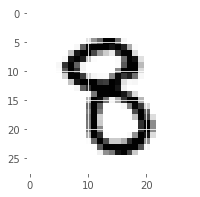

8.0


In [230]:
idx = random.randint(0, data.shape[0])
show_2d(data[idx,:,:].reshape((28,28)))
print(dataset.target[idx])


In [383]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
in_sample_classes = model.predict(trainX, batch_size=batch_size)
print(classification_report(trainY.argmax(axis=1),
                            in_sample_classes.argmax(axis=1),
                            target_names=[str(x) for x in lb.classes_]))

[INFO] Evaluating network...
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4665
        1.0       1.00      1.00      1.00      5250
        2.0       1.00      1.00      1.00      4700
        3.0       1.00      1.00      1.00      4756
        4.0       1.00      1.00      1.00      4568
        5.0       1.00      1.00      1.00      4225
        6.0       1.00      1.00      1.00      4584
        7.0       1.00      1.00      1.00      4874
        8.0       1.00      1.00      1.00      4585
        9.0       1.00      1.00      1.00      4693

avg / total       1.00      1.00      1.00     46900



In [384]:
target_names=[str(x) for x in lb.classes_]
target_digits = testY.argmax(axis=1)
prediction_digits = predictions.argmax(axis=1)
misses = target_digits != prediction_digits
miss_indices = [index for index,val in enumerate(misses) if val == True]

print(target_digits.shape)
print(prediction_digits.shape)
print(len([val for val in misses if val == True]))
print(len(miss_indices))
print(miss_indices[0:30])



(23100,)
(23100,)
258
258
[114, 183, 262, 517, 527, 614, 675, 724, 1036, 1040, 1080, 1236, 1271, 1337, 1376, 1465, 1694, 1706, 1812, 1905, 2180, 2239, 2243, 2411, 2482, 2559, 2649, 2735, 2779, 2805]


In [11]:
def show_2d(im, figsize_x=3, cmap='Greys'):
    plt.figure(figsize=(figsize_x, figsize_x))
    plt.imshow(im, cmap=cmap)
    plt.show()

In [12]:
def show_flattened(im, figsize_x=3, cmap='Greys'):
    im = im.reshape(28,28)
    show_2d(im, figsize_x, cmap)

In [13]:
def diagnose(im):
    pred = model.predict(im, batch_size=1)
    print('Predicted {0}'.format(pred.argmax(axis=1)))
    show_flattened(im)

(23100, 28, 28, 1)
6621
(28, 28, 1)
[0.002 0.    0.009 0.    0.    0.    0.    0.989 0.    0.   ]
Target = 2.0, Prediction=7.0


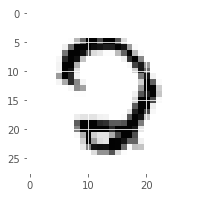

In [394]:
# Show examples of mis-classified digits from the test set
print(testX.shape)
idx = miss_indices[random.randint(0,len(miss_indices))]
im = testX[idx,:]
print(idx)
print(im.shape)
print(np.round(predictions[idx,:],3))
digit = testY[idx].argmax()
print('Target = {}, Prediction={}'.format(target_names[digit], target_names[prediction_digits[idx]]))
#diagnose(im)
show_flattened(im)

(23100, 28, 28, 1)
15584
(28, 28, 1)
Target = 4.0, Prediction=4.0


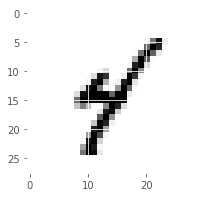

In [387]:
# Show random test digits with predict/target values.  
print(testX.shape)
idx = random.randint(0,testY.shape[0])
im = testX[idx,:]
print(idx)
print(im.shape)
digit = testY[idx].argmax()
print('Target = {}, Prediction={}'.format(target_names[digit], target_names[prediction_digits[idx]]))
#diagnose(im)
show_flattened(im)

In [143]:
plt.style.use('ggplot')
plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>